# Pairwise MLP with PU

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- cone around the candidate trackster


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import random_split, DataLoader
from reco.loss import QualityFocalLoss

from reco.datasetPU import TracksterPairs
from reco.training import precision_recall_curve, roc_auc

ds_name = "CloseByPion200PU"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=50,
    radius=15,
    pileup=True,
    bigT_e_th=5,
)

ds[0][0]
ds.x.shape

torch.Size([90003, 63])

In [4]:
print(ds.x.shape)

print("Positive:", int((ds.y > 0.7).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.7).type(torch.int).sum()))

torch.Size([90003, 63])
Positive: 34372
Negative: 55631


In [5]:
balance =  float(sum(ds.y > 0.7) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

dataset balance: 38.19% / 61.81%


In [6]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = DataLoader(test_set, batch_size=32, shuffle=True)

Train samples: 81003, Test samples: 9000


In [7]:
def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

In [8]:
hdim1 = 256
hdim2 = 128

model = nn.Sequential(
    nn.LayerNorm(ds.x.shape[1]),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.Sigmoid(),
    nn.Linear(hdim1, hdim2),
    nn.Sigmoid(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
)
model = model.to(device)
epochs = 101
model_path = f"models/PairWiseMLP.PU.{hdim1}.{hdim2}.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [9]:
#%%script echo skipping

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)
loss_obj = QualityFocalLoss(gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, val auc: {test_auc:.4f}')

torch.save(model.state_dict(), model_path)

Epoch: 0, loss: 220.1819, train auc: 0.9185, val auc: 0.9146


KeyboardInterrupt: 

In [ ]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


In [ ]:
roc_auc(model, device, test_dl)

0.931110112875305

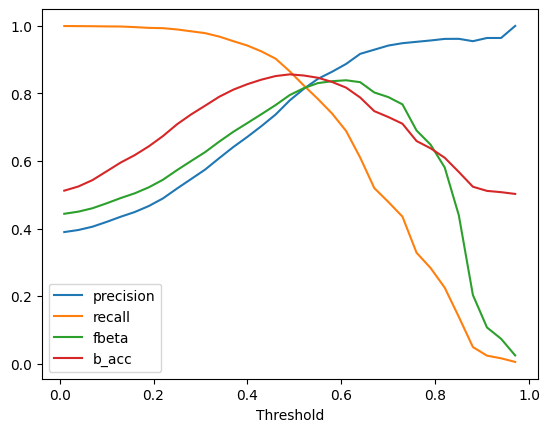

TP: 2379, TN: 5245, FP: 302, FN: 1074
TH: 0.61 precision: 0.887 recall: 0.689 fbeta: 0.839 b_acc: 0.817


In [ ]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3)

## Results

- hdim: (256, 128), roc_auc = 0.9956
- hdim: (512, 512), roc_auc = 0.9605 (overfit?) (test auc going down)
- hdim: (256, 256), alpha=1-balance, roc_auc = 0.9635 (overfit?) (test auc going down)


# ONNX export

In [ ]:
import torch.onnx

onnx_filepath = f"onnx/PairWiseMLP.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.onnx"

In [ ]:
torch.onnx.export(
    model,                      # model to be exported
    ds[0][0].reshape(1, -1),    # example input (add batch dimension)
    onnx_filepath,
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=['features'],      # the model's input names
    output_names=['output'],    # the model's output names
    dynamic_axes={              # variable length axes
        'features' : {0 : 'batch_size'},    
        'output' : {0 : 'batch_size'}
    }
)

In [ ]:
import numpy as np
import onnxruntime

ort_session = onnxruntime.InferenceSession(onnx_filepath)

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [ ]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(ds[:16][0])}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
torch_out = model(ds[:16][0])
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


## Evaluation

In [ ]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15643817_2.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name, pileup=True)

In [ ]:
result = model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    DummyPleaser(),
    decision_th=0.5,
    radius=15,
    max_events=10,
    reco_eval=False,
    bigT_e_th=5,
    pileup=True
)

Event 0:
	clue3d_to_sim:	P: 0.802 R: 0.307 F: 0.607
	target_to_sim:	P: 0.718 R: 0.727 F: 0.720
Event 1:
	clue3d_to_sim:	P: 0.993 R: 0.335 F: 0.713
	target_to_sim:	P: 0.984 R: 0.427 F: 0.780
Event 2:
	clue3d_to_sim:	P: 0.955 R: 0.221 F: 0.573
	target_to_sim:	P: 0.925 R: 0.430 F: 0.752
Event 3:
	clue3d_to_sim:	P: 0.976 R: 0.793 F: 0.933
	target_to_sim:	P: 0.960 R: 0.823 F: 0.929
Event 4:
	clue3d_to_sim:	P: 0.727 R: 0.595 F: 0.696
	target_to_sim:	P: 0.711 R: 0.633 F: 0.694
Event 5:
	clue3d_to_sim:	P: 1.000 R: 0.511 F: 0.839
	target_to_sim:	P: 1.000 R: 0.566 F: 0.867
Event 6:
	clue3d_to_sim:	P: 0.971 R: 0.500 F: 0.817
	target_to_sim:	P: 0.926 R: 0.691 F: 0.867
Event 7:
	clue3d_to_sim:	P: 0.974 R: 0.353 F: 0.721
	target_to_sim:	P: 0.967 R: 0.597 F: 0.860
Event 8:
	clue3d_to_sim:	P: 0.881 R: 0.306 F: 0.640
	target_to_sim:	P: 0.816 R: 0.442 F: 0.698
Event 9:
	clue3d_to_sim:	P: 0.994 R: 0.095 F: 0.343
	target_to_sim:	P: 0.996 R: 0.371 F: 0.745
-----
mean clue3d_to_sim:	P: 0.927 R: 0.402 F: 0.6

In [53]:
r_ranges = range(5, 25, 5)
results = []

max_events = 20
clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=10,
        pileup=True
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    naive_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=20,
        bigT_e_th=10,
        pileup=True
    )
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.930 R: 0.176 F: 0.501
	target_to_sim:	P: 0.916 R: 0.223 F: 0.565
	reco_to_sim:	P: 0.756 R: 0.231 F: 0.520
Event 1:
	clue3d_to_sim:	P: 0.957 R: 0.145 F: 0.451
	target_to_sim:	P: 0.955 R: 0.187 F: 0.524
	reco_to_sim:	P: 0.955 R: 0.187 F: 0.524
Event 2:
	clue3d_to_sim:	P: 0.896 R: 0.118 F: 0.386
	target_to_sim:	P: 0.852 R: 0.180 F: 0.487
	reco_to_sim:	P: 0.669 R: 0.184 F: 0.438
Event 3:
	clue3d_to_sim:	P: 0.969 R: 0.087 F: 0.320
	target_to_sim:	P: 0.972 R: 0.232 F: 0.593
	reco_to_sim:	P: 0.896 R: 0.246 F: 0.586
Event 4:
	clue3d_to_sim:	P: 0.993 R: 0.216 F: 0.578
	target_to_sim:	P: 0.993 R: 0.288 F: 0.667
	reco_to_sim:	P: 0.960 R: 0.295 F: 0.662
Event 5:
	clue3d_to_sim:	P: 0.786 R: 0.064 F: 0.240
	target_to_sim:	P: 0.803 R: 0.225 F: 0.531
	reco_to_sim:	P: 0.715 R: 0.225 F: 0.498
Event 6:
	clue3d_to_sim:	P: 0.652 R: 0.006 F: 0.027
	target_to_sim:	P: 0.652 R: 0.006 F: 0.027
	reco_to_sim:	P: 0.587 R: 0.050 F: 0.187
Event 7:
	clue3d_to

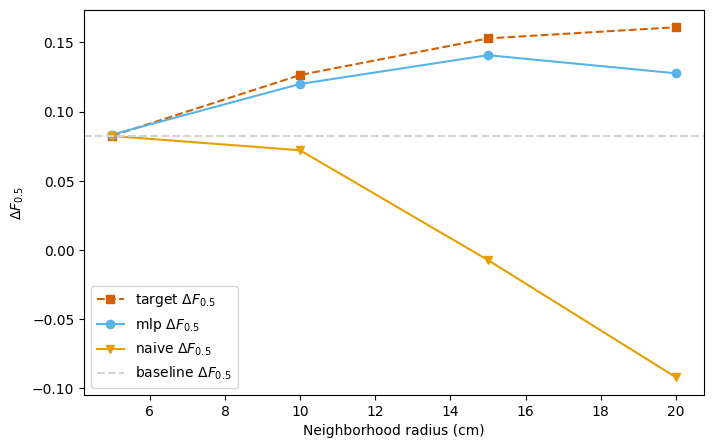

In [54]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="mlp $\Delta F_{0.5}$", c="#56B4E9")
ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline $\Delta F_{0.5}$", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")

fig.savefig(f'export/{ds_name}-e10-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [7]:
eth_ranges = [0, 5, 10, 20, 40, 60]
r_ranges = range(10, 25, 5)
eth_results = []

max_events = 10

for r in r_ranges:
    _clue3D_F = []
    _target_F = []
    for eth in eth_ranges:
        print(f" --- Eth: {eth} | Radius threshold: {r} ---")
        result = model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=r,
            bigT_e_th=eth,
            max_events=max_events,
            pileup=True,
            reco_eval=False
        )
        # ignore cases where there is nothing to do
        c3d = np.array(result["clue3d_to_sim"])[:,2]
        tgf = np.array(result["target_to_sim"])[:,2]
        # cmp_idx = c3d != tgf
        # c3d = c3d[cmp_idx] 
        # tgf = tgf[cmp_idx] 
        _clue3D_F.append(np.sum(c3d) / max_events)
        _target_F.append(np.sum(tgf) / max_events)
    eth_results.append(np.array(_target_F) - np.array(_clue3D_F))

 --- Eth: 0 | Radius threshold: 10 ---
Event 0:
	clue3d_to_sim:	P: 0.805 R: 0.309 F: 0.609
	target_to_sim:	P: 0.763 R: 0.447 F: 0.669
Event 1:
	clue3d_to_sim:	P: 0.987 R: 0.335 F: 0.711
	target_to_sim:	P: 0.987 R: 0.421 F: 0.778
Event 2:
	clue3d_to_sim:	P: 0.947 R: 0.222 F: 0.573
	target_to_sim:	P: 0.925 R: 0.430 F: 0.752
Event 3:
	clue3d_to_sim:	P: 0.963 R: 0.794 F: 0.923
	target_to_sim:	P: 0.960 R: 0.909 F: 0.950
Event 4:
	clue3d_to_sim:	P: 0.727 R: 0.595 F: 0.696
	target_to_sim:	P: 0.727 R: 0.595 F: 0.696
Event 5:
	clue3d_to_sim:	P: 1.000 R: 0.511 F: 0.839
	target_to_sim:	P: 1.000 R: 0.538 F: 0.853
Event 6:
	clue3d_to_sim:	P: 0.963 R: 0.500 F: 0.812
	target_to_sim:	P: 0.925 R: 0.690 F: 0.866
Event 7:
	clue3d_to_sim:	P: 0.970 R: 0.354 F: 0.720
	target_to_sim:	P: 0.967 R: 0.835 F: 0.938
Event 8:
	clue3d_to_sim:	P: 0.868 R: 0.308 F: 0.637
	target_to_sim:	P: 0.811 R: 0.444 F: 0.696
Event 9:
	clue3d_to_sim:	P: 0.996 R: 0.137 F: 0.441
	target_to_sim:	P: 0.996 R: 0.371 F: 0.745
-----
mean 

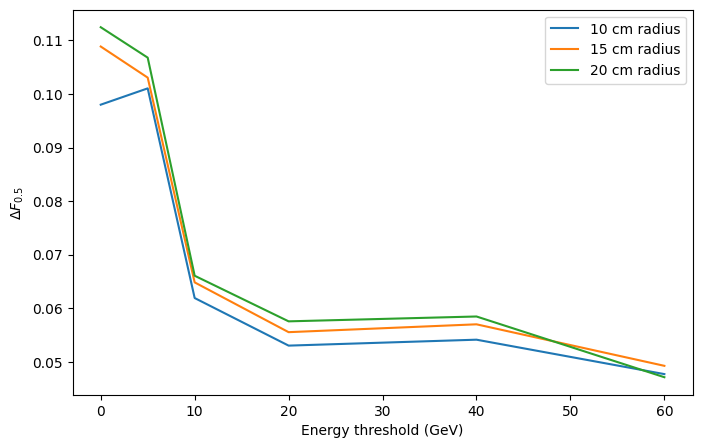

In [8]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

for r, res in zip(r_ranges, eth_results):
    ax.plot(eth_ranges, res, label=f"{r} cm radius")

ax.legend()
# ax.set_xlim(0, 100)
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("$\Delta F_{0.5}$")

# outcome: 10 cm makes sense for PU, not higher

fig.savefig(f'export/{ds_name}-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [25]:
max(eth_results[2])

0.11243884202745069